# Support Vector Machine (SVM) VS Neural Network

En este notebook se comparan los algoritmos de Máquinas de Soporte Vectorial, *SVM* por sus siglas en inglés, y Redes Neuronales para predecir el consumo de unos vehículos.

## Tabla de contenidos

- [Carga y análisis descriptivo de los datos](#Carga-y-análisis-descriptivo-de-los-datos)
- [Tratamiento de missing values](#Tratamiento-de-missing-values)
- [Conjuntos de entrenamiento y validación](#Conjuntos-de-entrenamiento-y-validación)
- [Normalización de datos](#Normalización-de-datos)
- [Máquinas de Soporte de Vectores](#Máquinas-de-Soporte-de-Vectores)
  - [Entrenamiento SVR](#Entrenamiento-SVR)
  - [Validación SVR](#Validación-SVR)
  - [Estimación de errores de SVR](#Estimación-de-errores-de-SVR)
- [Redes Neuronales](#Redes-Neuronales)
  - [Entrenamiento MLP](#Entrenamiento-MLP)
  - [Validación MLP](#Validación-MLP)
  - [Estimación de errores de MLP](#Estimación-de-errores-de-MLP)
- [Conclusiones](#Conclusiones)
- [Anexo - Análisis de relaciones entre variables](#Anexo---Análisis-de-relaciones-entre-variables)

In [1]:
### Funciones auxiliares

import datetime
import errno
import math
import os
import sys

# Función para validar que el fichero existe
def assert_fichero(nombre):
    if (not os.path.isfile(nombre)):
        raise FileNotFoundError(errno.ENOENT, os.strerror(errno.ENOENT), nombre)
        
# Función para imprimir mensajes por la salida de error
def eprint(*args, **kwargs):
    print(*args, file=sys.stderr, **kwargs)

# Calcula la recta de ajuste a los juegos de datos X e Y
from sklearn.linear_model import LinearRegression
def recta_ajuste(X, Y):
    """
    :param X: serie de valores de x
    :param Y: serie de valores de y
    :return: (X, Valores Y de la recta de ajuste)
    """
    reg = LinearRegression().fit(X.reshape(-1, 1), Y)
    
    x_recta = np.array([min(X), max(X)])
    return (x_recta, reg.predict(x_recta.reshape(-1, 1)))

# Función para mostrar hisogramas del dataframe
def mostrar_histogramas(df, titulo, column=None,n_rows=3, n_cols=2,bins=12):
    fig=plt.figure()
    variables = df.columns if column == None else column
    indiceSubplot = 0
    for nombre_variable in variables:
        # Se pintan solo aquellos histogramas que no tengan valores N/A 
        if (pd.to_numeric(df[nombre_variable],errors='coerce').isnull().any() == False):
            ax=fig.add_subplot(n_rows,n_cols,indiceSubplot+1)
            df[nombre_variable].hist(bins=bins,ax=ax)
            ax.set_title('Distribución '+ nombre_variable)
            indiceSubplot+=1
    fig.suptitle(titulo, y=1.05, fontsize=12, fontweight="bold")
    fig.tight_layout()
    plt.show()

from sklearn.metrics import mean_squared_error, mean_absolute_error, \
    mean_squared_log_error, r2_score
def calcular_errores(Y_real, Y_predict, modelo, mostrar=True):
    # Error cuadrático medio
    mse = mean_squared_error(Y_real, Y_predict)

    # Raíz del error cuadrático medio
    rmse = math.sqrt(mse)

    # Error medio absoluto
    mae = mean_absolute_error(Y_real, Y_predict)

    # Logaritmo de la raíz del error cuadrático medio
    rmlse = math.sqrt(mean_squared_log_error(Y_real, Y_predict))

    # Para verificar se calcula de nuevo el estimador R2
    r2 = r2_score(Y_real, Y_predict)

    if mostrar:
        print('{} - MSE: {:.2f}'.format(modelo, mse))
        print('{} - RMSE: {:.2f}'.format(modelo, rmse))
        print('{} - MAE: {:.2f}'.format(modelo, mae))
        print('{} - RMLSE: {:.2f}'.format(modelo, rmlse))
        print('{} - R\N{SUPERSCRIPT TWO}: {:.2f}'.format(modelo, r2))
    
    return {'mse': mse, 'rmse': rmse, 'mae': mae, 'rmlse': rmlse, 'r2': r2}

# Función para generar la gráfica de comparación de predicciones
import matplotlib.pyplot as plt
%matplotlib inline
def mostrar_grafica_comparacion_predicciones(Y_predict, Y_real, r2_score, tipo, title, mostrar=True):
    lw = 2 # Grosor de los elementos de la gráfica
    
    # Diagonal ó recta de ajuste perfecto
    diagonal = [min(Y_real), max(Y_real)]
    plt.plot(diagonal, diagonal, color='coral', lw=lw,
             linestyle='--', label='Ajuste perfecto')

    # Recta de mejor ajuste entre valores reales y valores predichos
    (x_ajuste, y_ajuste) = recta_ajuste(Y_predict, Y_real)
    pendiente = (y_ajuste[1] - y_ajuste[0]) / (x_ajuste[1] - x_ajuste[0])
    interseccion_y = y_ajuste[0] - pendiente*x_ajuste[0]
    
    plt.plot(x_ajuste, y_ajuste, color='turquoise', lw=lw,
             linestyle='-.', label='Ajuste: {:.3f} + {:.3f}x'.format(interseccion_y, pendiente))
    
    # Representación de los valores predichos frente a los reales
    plt.scatter(Y_predict, Y_real, color='indigo', lw=lw, marker='.',
                label='{} (R\N{SUPERSCRIPT TWO} = {:.2f})'.format(tipo, r2_score))

    plt.xlabel('Valor predicción')
    plt.ylabel('Valor real')
    plt.title(title)
    plt.legend()
    
    if mostrar:
        plt.show()

## Carga y análisis descriptivo de los datos

In [2]:
import pandas as pd
import numpy as np

# Comprobación de que el fichero de datos está disponible
fichero_datos = 'auto-mpg.data'
assert_fichero(fichero_datos)

# Lectura del fichero de datos
## Se indica el nombre de las columnas tomado del archivo auto-mpg.names
columnas_datos = ['mpg', 'cylinders', 'displacement', 'horsepower',
                  'weight', 'acceleration', 'model_year', 'origin', 'car_name']

## Se carga el archivo como un DataFrame de Pantas donde el separador entre
## columnas es uno o más espacios, y se indica que el archivo no tiene cabecera
df_raw = pd.read_csv(fichero_datos, names=columnas_datos,
                     header=None, sep='\s+')

# Muestra las primeras columnas del DataFrame cargado
df_raw.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,car_name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino


Como puede verse en la tabla, se dispone de un total de 9 columnas, todas ellas numéricas a excepción de la última columna, `car_name`.

Según el fichero `auto-mpg.names` cada valor de la columna `car_name` es único y sirve para ponerle nombre a cada registro, por lo que carece de valor predictivo y se prescindirá de ella como una posible *feature*.

La variable `origin` puede tomar los valores `1`, `2` ó `3` y tampoco parece que vaya a tener un papel importante como variable predictiva, así que también se va a dejar fuera del conjunto de *feautures*.

El resto de variables sí parecen ser relevantes para poder predecir el consumo de los vehículos, es decir, las *millas por galón* o `mpg`.

### Suposiciones sobre relaciones de variables

Para hacer una interpretación correcta del significado de los predictores hay que tener en cuenta que *millas por galón* es inversamente proporcional al consumo del vehículo, es decir, un coche con mayor consumo debería tener un `mpg` menor que un coche de menor consumo, por tanto:

- `cylinders`: Se trata del número de cilindros del motor y es una variable discreta no binaria. Es de suponer que a más cilindros, mayor será el consumo.
- `displacement`, `horsepower`, `weight` y `acceleration`: Estas variables son todas contínuas, y todas ellas parecen indicar que a mayor valor se producirá un mayor consumo. Por ejemplo, a mayor `displacement` el vehículo estará más desgastado y consumirá más; a mayor `horsepower` mayor será la potencia del motor y mayor será su consumo; a mayor `weight` más peso tendrá el vehículo y por tanto consumirá más combustible; y la `acceleration`, también relacionada con la potencia del motor, estará directamente relacionada con el consumo del vehículo.
- `model_year`: Finalmente, el año del modelo, es una variable discreta no binaria, que intuitivamente se podría pensar que a menor año, el vehículo tendrá mayor consumo por ser más antiguo.

(Para una ayuda visual y corroboración de estas suposiciones puede consultarse el [Anexo - Análisis de relaciones entre variables](#Anexo---Análisis-de-relaciones-entre-variables))

A continuación se muestra una tabla con una serie de estadísticas sobre las variables de interés:

In [3]:
# Descripción de las features discretas
features = ['cylinders', 'displacement', 'horsepower',
            'weight', 'acceleration', 'model_year']

# Describe estadísticamente el contenido del DataFrame de las
# columnas de las features
df_raw[features].describe()

,cylinders,displacement,weight,acceleration,model_year
count,398.000000,398.000000,398.000000,398.000000,398.000000
mean,5.454774,193.425879,2970.424623,15.568090,76.010050
std,1.701004,104.269838,846.841774,2.757689,3.697627
min,3.000000,68.000000,1613.000000,8.000000,70.000000
25%,4.000000,104.250000,2223.750000,13.825000,73.000000
50%,4.000000,148.500000,2803.500000,15.500000,76.000000
75%,8.000000,262.000000,3608.000000,17.175000,79.000000
max,8.000000,455.000000,5140.000000,24.800000,82.000000


Lo primero que llama la atención es que la columna `horsepower` no se muestra. Esto es debido a que esta columna tiene valores desconocidos que deben ser correctamente filtrados previamente para su correcto uso como variable predictora. Esto se llevará a cabo en [Tratamiento de missing values](#Tratamiento-de-missing-values).

También puede verse en la tabla que el número total de registros leídos ha sido `398`, el cuál será un dato importante de cara a la gestión de *valores desconocidos* puesto que si el número de éstos es pequeño comparado con el número total de registros, podrá optarse por la solución más sencilla que consiste en descartarlos. De no ser así, habría que tomar otras medidas, como puede ser la sustitución de los valores desconocidos por la media de su correspondiente columna o por la moda, por ejemplo.

Otra forma interesante y más visual de describir los datos es mediante el uso de histogramas:

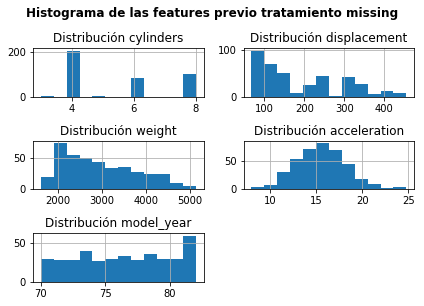

In [4]:
# Muestra los histogramas de las features
mostrar_histogramas(df_raw[features], 'Histograma de las features previo tratamiento missing')

De estos histogramas pueden sacarse las siguientes conclusiones:

- `cylinders`: Parece estar principalmente formada por vehículos de `4`, `6` u `8` cilindros.
- `displacement`: La mayor parte de los vehículos parece haberse desplazado menos de `250` millas.
- `weight`: El `75%` de los vehículos tiene un peso inferior a `3500` Kg
- `acceleration`: Esta variable parece seguir una distribución gaussiana.
- `model_year`: El año del modelo de los vehículos parece estar uniformemente distribuído a excepción de algunos años: `73` y `82`

## Tratamiento de missing values

Como primera aproximación se buscarán todos los valores desconocidos y se contará el número total de registros afectados por estos valores.

Si el número de registros con al menos un valor desconocido es inferior al `1-2%` del total de los registros leídos directamente se excluirán estos registros de la muestra total.

Si por el contrario, el número de registros afectados no es despreciable frente al total de registros, habrá que tomar otras medidas, como es la sustitución de los valores desconocidos por la media de su correspondiente columna.

El primero de los métodos es el preferible dado que es mejor perder un número despreciable de registros que completar un gran número de registros con datos que de alguna manera son inventados.

Como ya hemos visto que sólo la columna `horsepower` presenta problemas, vamos a centrar la búsqueda de *valores desconocidos* sobre ésta.

In [5]:
# Del archivo auto-mpg.names se sabe que el número de registros incompletos es 6
numero_registros_incompletos_esperados = 6

# Porcentaje máximo de datos incompletos permitido para eliminación directa
porcentaje_limite = 2.00

# La función to_numeric convierte cadenas de caracteres a tipo numérico.
## Aquellas cadenas que no pueda convertir las guardará como np.nan
## de modo que las entradas con valor NaN serán los registros incompletos.
df_raw['horsepower'] = pd.to_numeric(df_raw['horsepower'], errors='coerce')
df_incompletos = df_raw[df_raw['horsepower'].isnull()]

# Número de registros incompletos y porcentaje
numero_registros_incompletos = df_incompletos.shape[0]
porcentaje_registros_incompletos = 100 * numero_registros_incompletos / df_raw.shape[0]

print("En total hay %d registros incompletos." % numero_registros_incompletos)
if (numero_registros_incompletos != numero_registros_incompletos_esperados):
    eprint("El número de registros incompletos esperados: %d no "
           "coincide con el número de registros incompletos encontrado: %d" %
           (numero_registros_incompletos_esperados, numero_registros_incompletos))

# Elección del tratamiento de missing values en función del porcentaje de
# registros incompletos frente al total de registros del conjunto de datos.
if (porcentaje_registros_incompletos < porcentaje_limite):
  print("El número de registros incompletos, {:05.2f}%, es inferior a {:05.2f}% del total de registros."
        "\nSe eliminan directamente estos registros."
        .format(porcentaje_registros_incompletos, porcentaje_limite))
  
  # Eliminación de los registros con valor NaN
  df_raw.dropna(subset=['horsepower'], inplace=True)
    
else:
  eprint("El número de registros incompletos, {:05.2f}%, es superior al {:05.2f}% del total de registros."
         " Hay que hacer un tratamiento más exahustivo de los valores incompletos."
         .format(porcentaje_registros_incompletos, porcentaje_limite))

En total hay 6 registros incompletos.
El número de registros incompletos, 01.51%, es inferior a 02.00% del total de registros.
Se eliminan directamente estos registros.


Una vez se han limpiado correctamente los datos desconocidos, volvemos a mostrar los histogramas para que ver que todas las features están disponibles para su correcto uso. Además, se puede observar cómo la eliminación de los missing no ha afectado a la distribución que siguen los features.

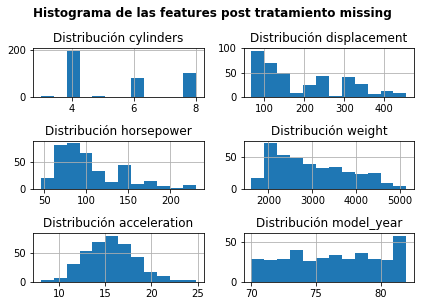

In [6]:
mostrar_histogramas(df_raw[features],'Histograma de las features post tratamiento missing')

## Conjuntos de entrenamiento y validación

Se separará el conjunto de datos proporcionados en dos grupos:

- uno con un 70% del total de los datos proporcionados que se usará para el entrenamiento de los modelos
- el 30% restante para el conjunto de validación

Los datos se repartirán aleatoriamente pero usando una semilla fija para facilitar la reproducibilidad de los resultados.

Para la separación de los conjuntos de entrenamiento y validación se usará el paquete de *scikit-learn*: [`sklearn.model_selection.train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)

In [7]:
from sklearn.model_selection import train_test_split

# Variable objetivo para predecir
target = 'mpg'

# Antes de continuar se estandarizan los tipos de datos a float64
# para evitar algunos warnings por tipados distintos
df_raw[features] = df_raw[features].astype(np.float64)

# Separación del conjunto de entrenamiento y de validación
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(
    df_raw[features], # Conjunto total de valores de X o features
    df_raw[target],   # Conjunto total de valores de y o target
    test_size=0.3,    # Porcentaje en tanto por 1 de entradas para validación
    random_state=109  # Establece una semilla fija para facilitar la reproducibilidad
)

Es importante que tras el reparto, tanto el conjunto de entrenamiento como el de validación cubran todo el espectro de datos disponibles.

Para el conjunto de entrenamiento esto es importante para tener cubierto todos los posibles casos y que el modelo esté preparado para predecir todas las situaciones posibles.

En el caso del conjunto de validación también es importante para garantizar que estamos comprobando de nuevo todo el espectro de posibilidades.

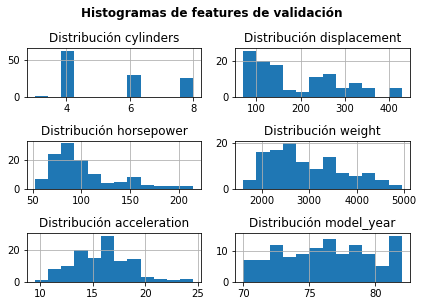

In [8]:
mostrar_histogramas(X_test_orig,'Histogramas de features de validación')

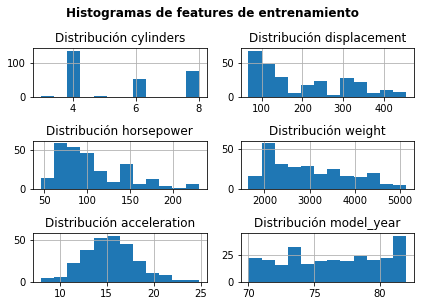

In [9]:
mostrar_histogramas(X_train_orig,'Histogramas de features de entrenamiento')

## Normalización de datos

Tanto para que los algoritmos de entramiento de los modelos tengan una convergencia más rápida como para que todas las funciones de activación de las redes de neuronas acepten los rangos de valores usados conviene hacer una conversión o *normalización* de los datos.

La normalización que se va a aplicar es la que implementa el paquete [`sklearn.preprocessing.StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) de *scikit-learn* y que normaliza los datos de manera que la media queda próxima a 0 y la desviación típica entorno a 1.

Esta *normalización será un punto clave del entrenamiento* de los modelos y dado que los modelos se entrenarán para predecir valores transformados, *habrá que aplicar la transformación inversa a las predicciones de los modelos para que éstas recuperen su significado real*.

Por tanto los objetos usados para la normalización de los datos formarán parte del modelo predictor.

De igual manera que se entrena un modelo predictor, sólo se usarán los registros del conjunto de entrenamiento para entrenar el *normalizador*.

Harán falta dos '*normalizadores*', uno para las *features* y otro para la variable *target*.

In [10]:
from sklearn.preprocessing import StandardScaler

# Entrenamiento del scaler para las features
X_scaler = StandardScaler()
X_scaler.fit(X_train_orig)

# Transformación de las features de entrenamiento y validación
X_train = X_scaler.transform(X_train_orig)
X_test = X_scaler.transform(X_test_orig)

# Entrenamiento del scaler para la variable target
y_scaler = StandardScaler()
y_scaler.fit(y_train_orig.values.reshape(-1, 1))

# Transformación del target de entrenamiento y validación
y_train = y_scaler.fit_transform(y_train_orig.values.reshape(-1, 1))[:,0]
y_test = y_scaler.transform(y_test_orig.values.reshape(-1, 1))[:,0]

Como comprobación pueden representarse los histogramas de las features de entrenamiento después de la normalización y compararse con las que previavemente se habían representado.

Se espera que aunque los valores del eje X de los histogramas hayan cambiado los histogramas deben tener la misma distribución cuantitativa y cualitativamente.

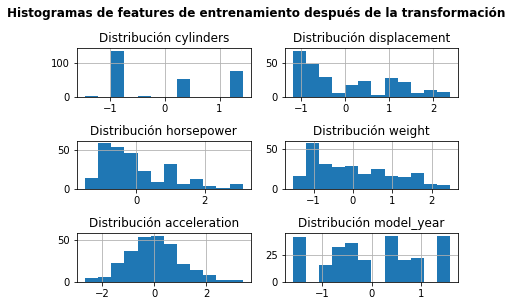

In [11]:
mostrar_histogramas(pd.DataFrame(X_train, columns=features), 
                    'Histogramas de features de entrenamiento después de la transformación')

Mientras que todos los histogramas conservan perfectamente la forma y los valores (a excepción del eje X debido a la transformación aplicada), llama la atención que en el caso de la feature `model_year` el histograma es claramente diferente.

La razón es que dado que se trata de una variable discreta de poco rango (13 valores), la transformación aplicada hace que las divisiones de los histogramas no sean exactamente iguales.

Una representación con un menor número de bines probablemente muestre formas similares para esta variable.

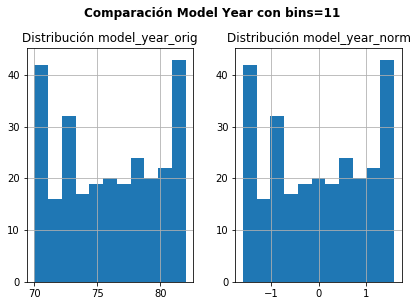

In [12]:
df_model_year = pd.DataFrame({
    'model_year_orig': X_train_orig.reset_index()['model_year'],             # feature model_year original con el índice reiniciado
    'model_year_norm': pd.DataFrame(X_train, columns=features)['model_year'] # feature model_year normalizada
})
mostrar_histogramas(df_model_year, 
                    'Comparación Model Year con bins=11',
                    n_rows=1,
                    n_cols=2,
                    bins=11)

## Máquinas de Soporte de Vectores

Para realizar el ajuste se usará el *kernel* `rbf`.

Como estimador de la predicción se va a usar el indicador $R^{2}$ que lo proporciona la función `score` del propio predictor `SVR`. Este indicador se mueve entre `0` y `1`, donde `0` indica el peor ajuste y `1` el mejor ajuste posible.

Para visualizar las predicciones la mejor manera es representar en el eje `X` los valores de la *predicción* y en el eje `Y` los valores reales.

### Entrenamiento SVR

Para realizar el entrenamiento se van a utilizar los paquetes de *scikit-learn*: [`sklearn.svm.SVR`](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html) y [`sklearn.model_selection.GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).

El primero de ellos es el módulo para operaciones con *máquinas de vector de soporte* para **regresiones**.

El segundo de ellos se usará para evaluar todas las posibles combinaciones de distintas parametrizaciones y determinar cuál de esas combinaciones es la que da un mejor resultado. La determinación de la mejor parametrización se realiza  mediante el método de *validación cruzada* o *k-fold*.

In [13]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

# Construcción del modelo con kernel 'rbf' y las distintas
# parametrizaciones que se desean probar
svr = GridSearchCV(
    SVR(kernel='rbf'), # Objeto predictor con kernel 'rbf'
    param_grid={
        'C': range(1, 20),             # Distintas posibilidades para soft-margin
        'gamma': np.logspace(-2, 2, 5) # Parámetro gamma del kernel rbf
    },
    cv=5,      # Determina el número de folds para la validación cruzada
    n_jobs=-1, # Aprovecha todos los hilos del procesador
    iid=False, # Para devolver la media de los scores de los folds
    refit=True # Para que tras encontrar la mejor parametrización se calibre el modelo con el dataset de entrenamiento completo
)

# Entrenamiento del modelo y determinación de la mejor parametrización
inicio = datetime.datetime.now()
svr.fit(X_train, y_train)
tiempo_entrenamiento_svr = datetime.datetime.now() - inicio

# Determinación de la bondad del ajuste
r2_svr = svr.score(X_test, y_test)
print("SVR - Mejor parametrización:",
      svr.best_params_,
      "| R\N{SUPERSCRIPT TWO}: {:.2f}".format(r2_svr))
print("SVR - Tiempo total de entrenamiento:", tiempo_entrenamiento_svr)

SVR - Mejor parametrización: {'C': 9, 'gamma': 0.1} | R²: 0.88
SVR - Tiempo total de entrenamiento: 0:00:01.788216


### Validación SVR

Una vez se ha determinado cuál es la mejor parametrización y se ha entrenado el modelo, se pueden realizar predicciones para el set de test y así determinar cómo de bueno es el modelo a la hora de realizar predicciones.

Es importante puntualizar que dado que el modelo está entrenedano para trabajar con los valores normalizados (ver [Normalización de datos](#Normalización-de-datos)), habrá que aplicar la transformación inversa a las predicciones obtenidas para recuperar los valores con *significado real* para el problema que se pretende resolver.

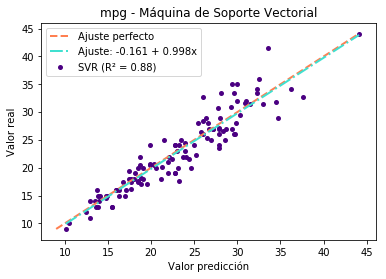

In [14]:
# Generación de predicciones para el conjunto de validación (normalizado)
y_predict_svr_norm = svr.predict(X_test)

# Transformación inversa sobre las predicciones para deshacer la normalización
y_predict_svr_orig = y_scaler.inverse_transform(y_predict_svr_norm)

# Representación
mostrar_grafica_comparacion_predicciones(y_predict_svr_orig, y_test_orig, r2_svr,
                                         'SVR', 'mpg - Máquina de Soporte Vectorial')

### Estimación de errores de SVR

A continuación se muestran los errores relativos cometidos en la predicción para poder determinar si las predicciones son o no buenas en base a los distintos estimadores de error.

In [15]:
errores_svr = calcular_errores(y_test_orig, y_predict_svr_orig, 'SVR')

SVR - MSE: 5.79
SVR - RMSE: 2.41
SVR - MAE: 1.80
SVR - RMLSE: 0.09
SVR - R²: 0.88


## Redes Neuronales

En este caso el sistema predictor estará basado en una red neuronal que usará como algoritmo para resolver el ajuste de pesos el *solver* `adam` que se basa en un optimizador de gradiante estocástico.

De nuevo se usará el indicador $R^{2}$ como parámetro para determinar la bondad del modelo.

### Entrenamiento MLP

Igual que en el [entrenamiento para SVR](#Entrenamiento-SVR) se hará uso del paquete `GridSearchCV` para probar y determinar cuál es la parametrización que mejor se ajuste al problema que se pretende resolver.

Para el entrenamiento de la red neuronal se hará uso del paquete [`sklearn.neural_network.MLPRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html) de *scikit-learn*. Esta clase permite determinar la topología de la red de neuronas, es decir, el número de capas ocultas así como el número de neuronas en cada capa, y permite indicar qué función de activación se quiere usar para entrenar el modelo.

En este caso, se plantean 9 posibles configuraciones de estructuras de capas de neuronas y 2 posibles funciones de activación: '*relu*' y '*tanh*'.

In [16]:
from sklearn.neural_network import MLPRegressor

# Construcción del modelo con solver 'adam' y las distintas
# parametrizaciones que se desean probar
mlp = GridSearchCV(
    MLPRegressor(solver='adam', max_iter=500, random_state=219),
    param_grid={
        'hidden_layer_sizes': (
            (10), (10, 10), (10, 10, 10),
            (70), (70, 70), (70, 70, 70),    
            (130), (130, 130), (130, 130, 130)  # Distintas configuraciones de capas y número de neuronas
        ),
        'activation': ('tanh', 'relu')          # Funciones de activación a probar
    },
    cv=5,      # Determina el número de folds para la validación cruzada
    n_jobs=-1, # Aprovecha todos los hilos del procesador
    iid=False, # Para devolver la media de los scores de los folds
    refit=True # Para que tras encontrar la mejor parametrización se calibre el modelo con el dataset de entrenamiento completo
)

# Entrenamiento del modelo y determinación de la mejor parametrización
inicio = datetime.datetime.now()
mlp.fit(X_train, y_train)
tiempo_entrenamiento_mlp = datetime.datetime.now() - inicio

r2_mlp = mlp.score(X_test, y_test)
print("MLP - Mejor parametrización:",
      mlp.best_params_,
      "| R\N{SUPERSCRIPT TWO}: {:.2f}".format(r2_mlp))
print("MLP - Tiempo total de entrenamiento:", tiempo_entrenamiento_mlp)

MLP - Mejor parametrización: {'activation': 'tanh', 'hidden_layer_sizes': (70, 70, 70)} | R²: 0.87
MLP - Tiempo total de entrenamiento: 0:00:07.365407


### Validación MLP

De nuevo, para dotar de pleno significado a las predicciones proporcionadas por el modelo es necesario aplicar la transformación inversa de `y_scaler` para que las predicciones obtenidas se ajusten a la escala original.

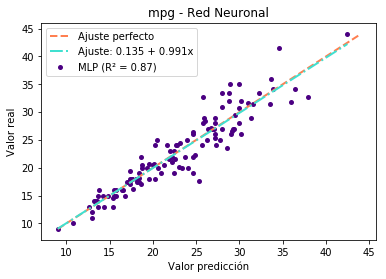

In [17]:
# Generación de predicciones para el conjunto de validación (normalizado)
y_predict_mlp_norm = mlp.predict(X_test)

# Transformación inversa sobre las predicciones para recuperar la escala
y_predict_mlp_orig = y_scaler.inverse_transform(y_predict_mlp_norm)

# Representación
mostrar_grafica_comparacion_predicciones(y_predict_mlp_orig, y_test_orig, r2_mlp,
                                         'MLP', 'mpg - Red Neuronal')

### Estimación de errores de MLP

De manera análoga al cálculo de las métricas de error del modelo SVR se han calculado los errores para el modelo de red neuronal.

In [18]:
errores_mlp = calcular_errores(y_test_orig, y_predict_mlp_orig, 'MLP')

MLP - MSE: 6.01
MLP - RMSE: 2.45
MLP - MAE: 1.83
MLP - RMLSE: 0.10
MLP - R²: 0.87


## Conclusiones

La principal conclusión es que ambos modelos predicen de manera muy similar todas las situaciones del conjunto de validación, obteniendo en ambos casos un factor $R^{2}$ muy parecido, ligeramente inferior a 0.9.

- Para el modelo *SVR* se ha obtenido un $R^{2}$ de *0.88* con `C=9` y `gamma=0.1`.

- Para el modelo *MLP* se ha obtenido un $R^{2}$ de *0.87* con *función de activación* `tanh` y configuración de *capas ocultas* de la red neuronal `(70, 70, 70)` (La configuración obtenida depende altamente del valor elegido para el parámetro `random_state` del objeto `MLPRegressor` dando configuraciones distintas con valores de $R^{2}$ muy parecidos. El `random_state` usado para estas conclusiones ha sido `219`, valor elegido al azar pero fijado para facilitar la reproducibilidad de los resultados).

Sin embargo, el modelo *SVR de la Máquina de Soporte Vectorial se situa ligeramente por delante del modelo MLP de la Red Neuronal* por los siguientes motivos:

- En todas las *métricas de error SVR obtiene valores menores que MLP* (aunque por muy poca diferencia), siendo las predicciones del primer modelo más precisas.

| Métrica de error | *SVR* | *MLP* |
|:------------:|:----------:|:----------:|
| *MSE* | `5.79` | `6.01` |
| *RMSE* | `2.41` | `2.45` |
| *MAE* | `1.80` | `1.83` |
| *RMLSE* | `0.09` | `0.10` |
| $R^{2}$ | `0.88` | `0.87` |

- El indicador $R^{2}$ es más alto en el caso de SVR que de MLP, lo que indica que el primero da una predicción que se ajusta más a los valores reales que el segundo. De nuevo, por muy poca diferencia. (El indicador $R^{2}$ permite comparar la calidad de los modelos fácilmente).
- El tiempo de selección de parametrización y entrenamiento es inferior para SVR que para MLP. Esto es un dato importante a tener en cuenta cuando se dispone de conjuntos de datos muy grandes. En este punto si se aprecia una gran diferencia entre ambos modelos.

In [19]:
print("SVR es {:.2f} veces más rápido que MLP.".format(tiempo_entrenamiento_mlp / tiempo_entrenamiento_svr))

SVR es 4.12 veces más rápido que MLP.


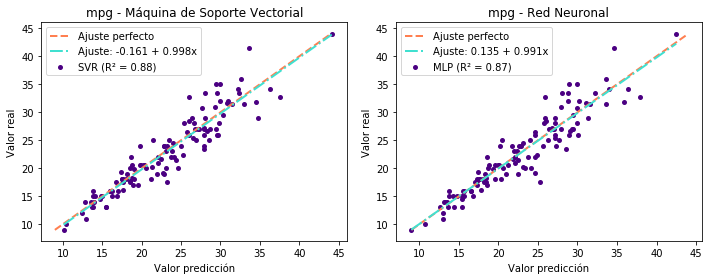

In [20]:
plt.subplots(1,2, figsize=(10,4), sharey=True)
plt.subplot(1, 2, 1)
mostrar_grafica_comparacion_predicciones(y_predict_svr_orig, y_test_orig, r2_svr,
                                         'SVR', 'mpg - Máquina de Soporte Vectorial',
                                         mostrar=False)

plt.subplot(1, 2, 2)
mostrar_grafica_comparacion_predicciones(y_predict_mlp_orig, y_test_orig, r2_mlp,
                                         'MLP', 'mpg - Red Neuronal',
                                         mostrar=False)

plt.tight_layout()
plt.show()

Atendiendo a las gráficas de manera conjunta pueden verse algunos detalles interesantes:

- Lo primero que llama la atención es que la recta de ajuste de los datos calculada como una regresión lineal por mínimos cuadrados con el paquete de *scikit-learn* [`sklearn.linear_model.LinearRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) cae justo encima de la recta de ajuste pefecto, que no es más que una recta de pendiente 1 y ordenada en el origen 0. Esto no quiere decir que el ajuste sea perfecto por caer sobre la recta de ajuste perfecto (si el ajuste fuese perfecto no habría dispersión en las predicciones), sino que las predicciones no tienen ninguna desviación sistemática, es decir, que no tienen ninguna tendencia sistemática a dar valores más altos o más bajos que los reales.

- Ambos modelos presentan una dispersión de puntos muy similar, lo que está en consonancia con haber obtenido un valor muy similar de $R^{2}$.

- Por otro lado, puede verse que a medida que el valor de `mpg` aumenta la dispersión de los puntos se va acentuando (este efecto se aprecia en los dos modelos por igual).

El efecto del aumento de la dispersión para altos valores de `mpg` puede deberse a que el número de datos de entrenamiento para esa región es pequeño y no se dispone de suficientes situaciones análogas para que el modelo sepa predecirlas con mayor exactitud.

Al representar el histograma de la variable *target*, `mpg`, se ve que a medida que aumenta el valor de la misma disminuye el número de ocurrencias de cada bin, lo que confirma que el modelo ha sido entrenado con menos datos para esa región que para la de menores `mpg`.

Si pudiesen obtenerse más datos para estas regiones de alto `mpg` podría entrenarse mejor el modelo y reducir el efecto de dispersión en esa región.

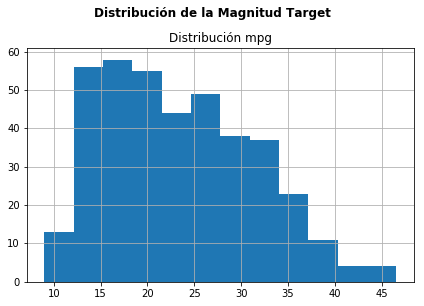

In [21]:
mostrar_histogramas(df_raw, 
                    column=['mpg'],
                    titulo='Distribución de la Magnitud Target',
                    n_rows=1,
                    n_cols=1)

## Anexo - Análisis de relaciones entre variables

A continuación se muestran una serie de gráficas en las que aparecen algunas de las *features* seleccionadas y la variable *target* y las dependencias entre ellas.

Este gráfico ayuda a corroborar de manera visual las hipótesis realizadas en el apartado [Suposiciones sobre relaciones de variables](#Suposiciones-sobre-relaciones-de-variables).

Por ejemplo:

- Atendiendo a la gráfica *mpg en función del número de cilindros* (subplot (1, 2)), los motores de 4 cilindros pueden llegar a tener más `mpg` que los de 6 ú 8 cilindros, como se había planteado inicialmente.

- Atendiendo a la gráfica *mpg en función del desplazamiento* (subplot (1, 3)), puede verse que a medida que aumenta el desplazamiento disminuyen las *millas por galón*. Esta es otra suposición que se había planteado al inicio.

- Finalmente, atendiendo a la gráfica *mpg en función del peso* (subplot (1, 4)), se confirma que el peso tiene una relación inversamente proporcional con las *millas por galón*, de modo que a más peso menor número de `mpg` tendrá ese vehículo.

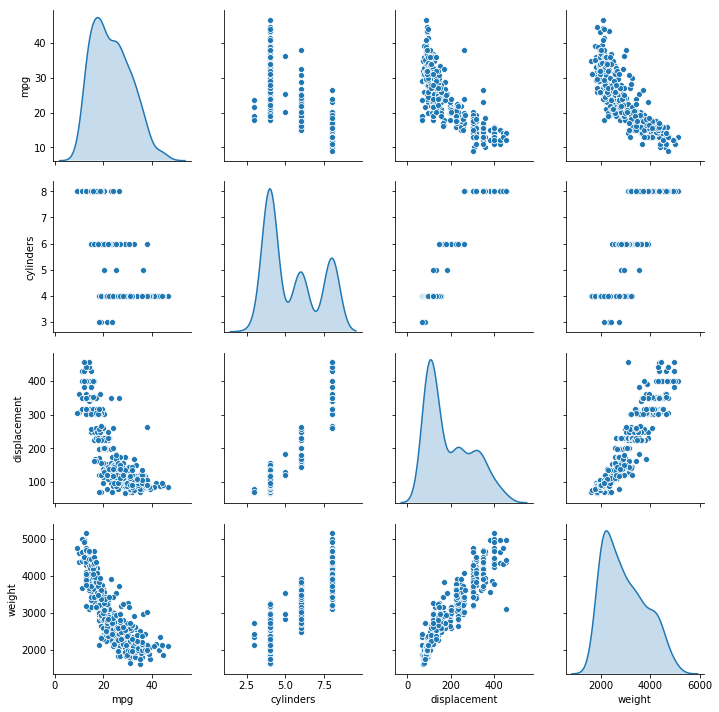

In [22]:
!pip install -q seaborn
import seaborn as sns
sns.pairplot(df_raw[["mpg", "cylinders", "displacement", "weight"]], diag_kind="kde")